# Table of Contents

* [Import libs](#libs)
* [Data Overview](#overview)
    * [Data Loading](#data-loading)
    * [Classes Distribution](#classses-distribution)
    * [Show Images](#show-images)
* [Preprocessing](#preprocessing)
    * [Remove background](#remove-bg)
    * [Train-val split](#train-val-split)
    * [Apply preprocessing](#apply-preprocessing)
    * [Generate Datasets](#gen=datasets)
* [Model Training](#model)
    * [Custom model](#custom-model)
    * [Transfer learning](#transfer-learning)
    * [Fine-tune model](#fine-tune)
* [Test data](#test-data)
     * [Preprocessing](#test-preprocessing)
     * [Inference](#inference)

<a id='libs'></a>
# Import libs

In [1]:
import zipfile

In [2]:



! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"denyskryvytskyi","key":"8e3ee93f5faeeed06acc4b682bea3cb4"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c ukraine-ml-bootcamp-2023

100% 451M/453M [00:14<00:00, 22.3MB/s]
100% 453M/453M [00:14<00:00, 32.1MB/s]


In [8]:
local_zip = 'ukraine-ml-bootcamp-2023.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [9]:
#!pip install rembg|

In [10]:
import shutil

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from rembg import remove


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Activation, GlobalAveragePooling2D, Average
from tensorflow.keras.layers import Resizing, Rescaling, CenterCrop
from tensorflow.keras.layers import RandomCrop, RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.preprocessing.image import ImageDataGenerator, smart_resize
from tensorflow.keras.utils import to_categorical, load_img, img_to_array, image_dataset_from_directory
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop, SGD
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, MobileNetV2, EfficientNetV2M, EfficientNetV2L
import tensorflow.keras.applications as applications
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB2, EfficientNetB7
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id='overview'></a>
# Data overview

<a id='data-loading'></a>
## Data loading

In [11]:
SUBMISSION_DATA_FILE_PATH = "/tmp/sample_submission.csv"
TRAIN_DATA_FILE_PATH = "/tmp/train.csv"

TRAIN_IMAGES_SRC_PATH = "/tmp/images/train_images/"
TEST_IMAGES_SRC_PATH = "/tmp/images/test_images/"

PREPROCESSED_TRAIN_IMAGES_SRC_PATH= "/tmp/preprocessed_train_images/"
PREPROCESSED_VAL_IMAGES_SRC_PATH= "/tmp/preprocessed_val_images/"

preprocessed_train_images_dir = "preprocessed_train_images"
if not os.path.exists(PREPROCESSED_TRAIN_IMAGES_SRC_PATH):
    os.mkdir(PREPROCESSED_TRAIN_IMAGES_SRC_PATH)

preprocessed_val_images_dir = "preprocessed_val_images"
if not os.path.exists(PREPROCESSED_VAL_IMAGES_SRC_PATH):
    os.mkdir(PREPROCESSED_VAL_IMAGES_SRC_PATH)

In [12]:
df = pd.read_csv(TRAIN_DATA_FILE_PATH)
df.head()

,image_id,class_6
0,1daf45401342ac321c0aa5668f51d004.jpg,5
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4
2,1dc97053cf67cb8e51c983abb0021083.jpg,4
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360 entries, 0 to 2359
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  2360 non-null   object
 1   class_6   2360 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.0+ KB


<a id='classses-distribution'></a>
## Classes Distribution

<Axes: title={'center': 'Classes distribution'}>

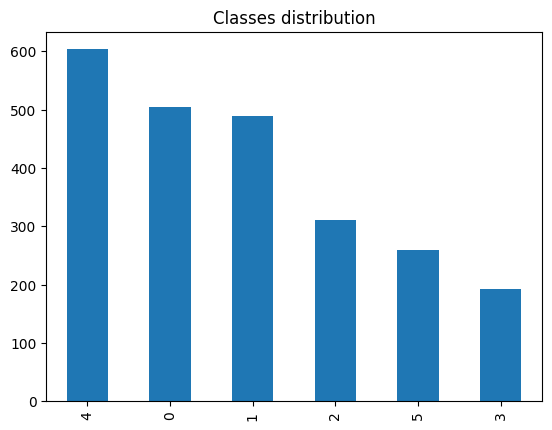

In [14]:
df['class_6'].value_counts().plot(kind='bar', title='Classes distribution')

<a id='show-images'></a>
## Show Images

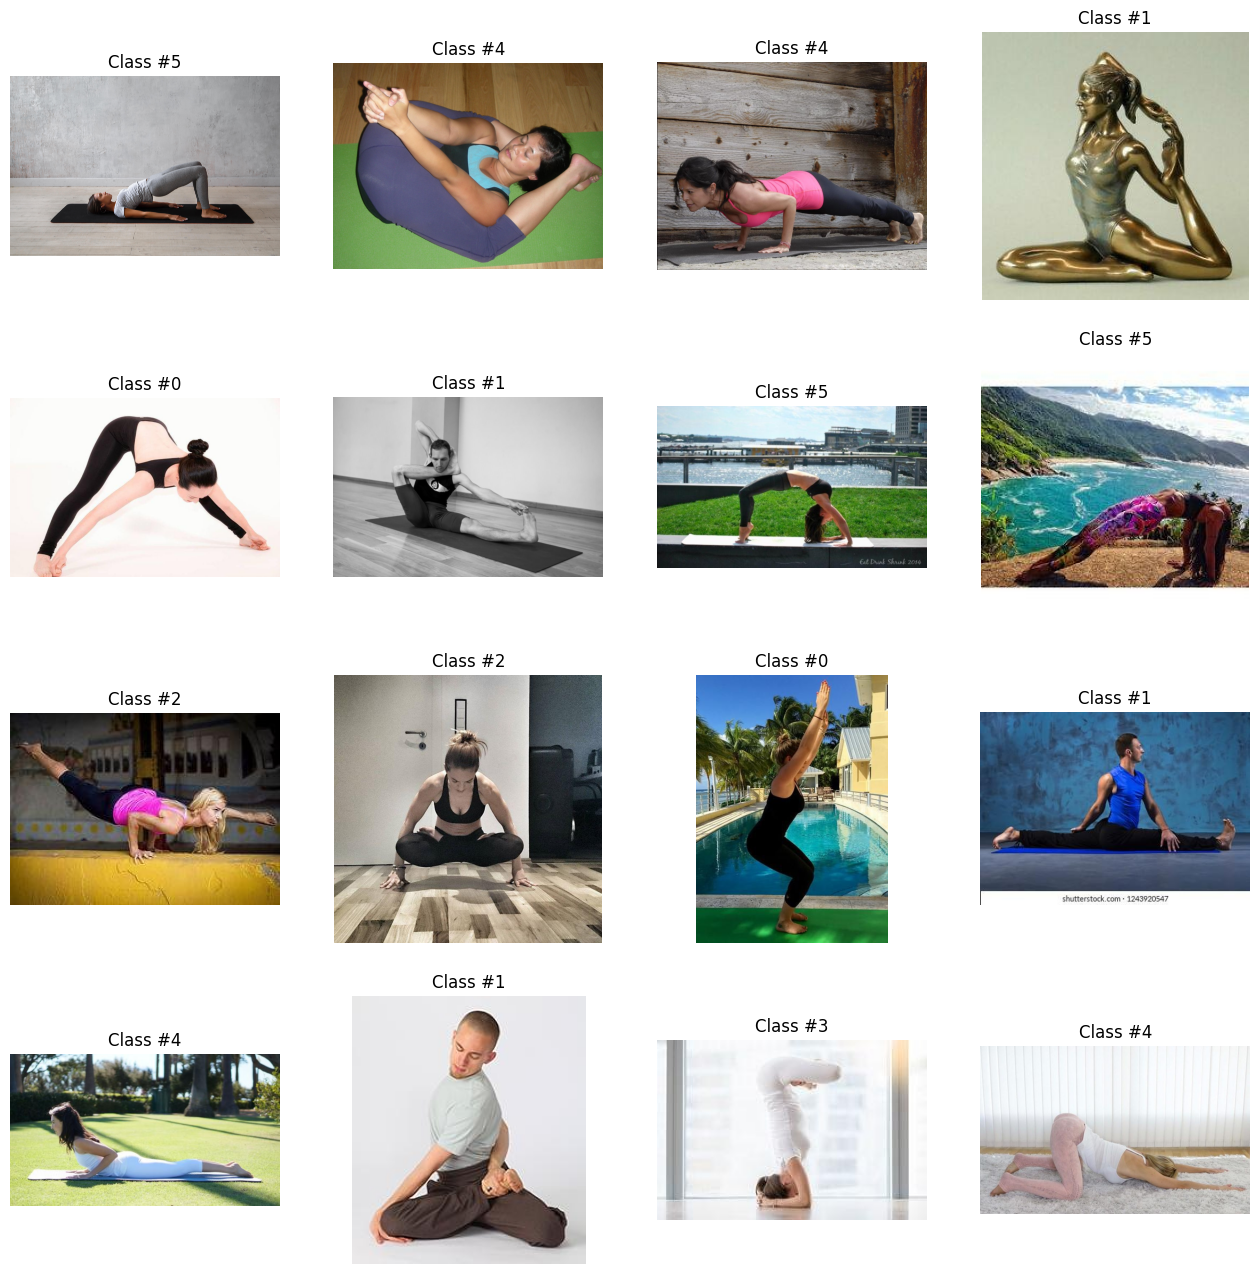

In [15]:
rows = 4
cols = 4
imgs_amount_to_show = rows * cols

fig = plt.gcf()
fig.set_size_inches(rows * 4, rows * 4)

for i in range(imgs_amount_to_show):
    img = load_img(TRAIN_IMAGES_SRC_PATH + df['image_id'][i])

    sp = plt.subplot(rows, cols, i + 1)
    sp.axis('Off')
    plt.title(f"Class #{df['class_6'][i]}")
    plt.imshow(img)

plt.show()

<a id='preprocessing'></a>
# Preprocessing

In [17]:
BATCH_SIZE = 16
IMG_SIZE = 256
VALIDATION_SPLIT = 0.1

<a id='train-val-split'></a>
## Train-val split

In [18]:
df['class_6'] = df['class_6'].astype(str)
train_df, val_df = train_test_split(df, test_size=VALIDATION_SPLIT, stratify=df['class_6'])
print(f'Train data shape: {len(train_df)}')
print(f'Validation data shape: {len(val_df)}')

Train data shape: 2124
Validation data shape: 236


<a id='remove-bg'></a>
## Remove background

In [19]:
def rembg(img_path):
    # Loading the image
    img = Image.open(img_path)

    # Removing the background from the given Image
    output = remove(img)

    return output

In [20]:
def test_rembg():
    for i in range(imgs_amount_to_show):
        img = rembg(TRAIN_IMAGES_SRC_PATH + df['image_id'][i])

        sp = plt.subplot(rows, cols, i + 1)
        sp.axis('Off')
        plt.title(f"Class #{df['class_6'][i]}")
        plt.imshow(img)

    plt.show()

In [21]:
#test_rembg()

<a id='apply-preprocessing'></a>
## Apply preprocessing

In [22]:
# The score is higher (with pretrained model) without erasing the background, so I commented on the logic behind that. You can uncomment it for experimentation.
# This function sorts images by classes into appropriate folders for now.
def preprocess_img(src_dir_path, res_dir_path, img_filename, class_name):
    src_full_path = os.path.join(src_dir_path, img_filename)
    #img = rembg(src_full_path)
    #img = img.convert("RGB")

    save_dir = os.path.join(res_dir_path, str(class_name))
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    save_full_path = os.path.join(save_dir, img_filename)
    #img.save(save_full_path, format="png")
    shutil.copy(src_full_path, save_full_path)

In [23]:
for index, row in train_df.iterrows():
    preprocess_img(TRAIN_IMAGES_SRC_PATH, PREPROCESSED_TRAIN_IMAGES_SRC_PATH, row.image_id, row.class_6)

for index, row in val_df.iterrows():
    preprocess_img(TRAIN_IMAGES_SRC_PATH, PREPROCESSED_VAL_IMAGES_SRC_PATH, row.image_id, row.class_6)

<a id='gen=datasets'></a>
## Generate Datasets

In [24]:
train_ds = image_dataset_from_directory(
    directory=PREPROCESSED_TRAIN_IMAGES_SRC_PATH,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation="bilinear"
)

val_ds = image_dataset_from_directory(
    directory=PREPROCESSED_VAL_IMAGES_SRC_PATH,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    interpolation="bilinear"
)

Found 2124 files belonging to 6 classes.
Found 236 files belonging to 6 classes.


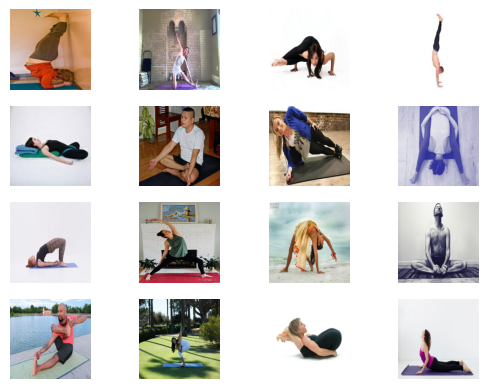

In [25]:
class_names = train_ds.class_names

for images, labels in train_ds.take(1):
    for i in range(len(images)):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

<a id='model'></a>

# Model training

In [26]:
def plot_model_history(history):
    # Plot the chart for accuracy and loss on both training and validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1_score = history.history['micro_f1_score']
    val_f1_score = history.history['val_micro_f1_score']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()

    plt.plot(epochs, f1_score, 'r', label='Training F1-score')
    plt.plot(epochs, val_f1_score, 'b', label='Validation F1-score')
    plt.title('Training and validation F1-score')
    plt.legend()

    plt.show()

In [27]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
#reduce_densenet_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-3)
early_stopping = EarlyStopping('val_loss', patience=15, restore_best_weights=True)

In [28]:
def micro_f1_score(y_true, y_pred):
    # Convert predictions to one-hot vectors
    y_pred = K.one_hot(K.argmax(y_pred), num_classes=6)

    # Calculate true positives, false positives, and false negatives over all classes
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    # Micro-average precision and recall
    micro_precision = K.sum(tp) / (K.sum(tp + fp) + K.epsilon())
    micro_recall = K.sum(tp) / (K.sum(tp + fn) + K.epsilon())

    # Calculate micro-averaged F1-score
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall + K.epsilon())

    return micro_f1

<a id='custom-model'></a>
## Custom Model

In [ ]:
def build_model():
    model=Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='inputLayer'),
        Rescaling(1./255),
        RandomFlip("horizontal"),
        RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
        RandomZoom(0.2),

        Conv2D(filters=32, kernel_size=5, activation="relu"),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(filters=64, kernel_size=5, activation="relu" ),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(filters=128, kernel_size=5, activation="relu" ),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(filters=256, kernel_size=3, activation="relu" ),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(filters=256, kernel_size=3, activation="relu" ),
        BatchNormalization(),
        MaxPooling2D(),

        Flatten(),
        Dense(units=128, activation="relu"),
        Dense(units=6, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss = 'categorical_crossentropy',
                  metrics=["accuracy", micro_f1_score])
    return model

In [ ]:
#custom_model = build_model()
#custom_model.summary()

In [ ]:
#history_custom_model = custom_model.fit(train_ds, validation_data = (val_ds), epochs=100, callbacks=[reduce_lr, early_stopping])

In [ ]:
#plot_model_history(history_custom_model)

<a id='transfer-learning'></a>
# Transfer Learning

In [29]:
def unfreeze_model(model, optimizer):
    # We unfreeze all layers, leaving the BatchNorm layers frozen to preserve model knowledge.
    for layer in model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", micro_f1_score])

## EfficientNet

In [ ]:
def build_efficientnet_model():
    base_model = EfficientNetV2M(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze the pretrained weights
    base_model.trainable = False

    # Augmantation sequence
    intput_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmantation = Sequential([
        #Rescaling(1/255),
        RandomFlip("horizontal"),
        RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
        RandomZoom(0.2)
    ])
    x = augmantation(intput_layer)

    # pretrain output
    pretrain_out = base_model(x, training = False)

    # Rebuild top
    x = GlobalAveragePooling2D()(pretrain_out)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(x)

    # Add a dropout rate
    x = Dropout(0.2)(x)

    # Output layer
    outputs = Dense(6, activation="softmax")(x)

    # Compile
    model = tf.keras.Model(inputs=intput_layer, outputs=outputs, name="EfficientNet")
    model.compile(optimizer=SGD(learning_rate=1e-2), loss="categorical_crossentropy", metrics=["accuracy", micro_f1_score])

    return model

In [ ]:
model_efficient = build_efficientnet_model()
model_efficient.summary()

214201816/214201816 [==============================] - 1s 0us/step
Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 320, 320, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                       

In [ ]:
history_efficient = model_efficient.fit(train_ds, validation_data = val_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
133/133 [==============================] - 71s 300ms/step - loss: 1.8379 - accuracy: 0.3343 - micro_f1_score: 0.3346 - val_loss: 1.5672 - val_accuracy: 0.5297 - val_micro_f1_score: 0.5306
Epoch 2/100
133/133 [==============================] - 35s 257ms/step - loss: 1.4214 - accuracy: 0.5108 - micro_f1_score: 0.5110 - val_loss: 1.3406 - val_accuracy: 0.5932 - val_micro_f1_score: 0.5958
Epoch 3/100
133/133 [==============================] - 34s 252ms/step - loss: 1.2549 - accuracy: 0.5692 - micro_f1_score: 0.5692 - val_loss: 1.2190 - val_accuracy: 0.5805 - val_micro_f1_score: 0.5847
Epoch 4/100
133/133 [==============================] - 34s 250ms/step - loss: 1.1595 - accuracy: 0.6069 - micro_f1_score: 0.6067 - val_loss: 1.1470 - val_accuracy: 0.6271 - val_micro_f1_score: 0.6306
Epoch 5/100
133/133 [==============================] - 35s 263ms/step - loss: 1.1046 - accuracy: 0.6365 - micro_f1_score: 0.6361 - val_loss: 1.1209 - val_accuracy: 0.6398 - val_micro_f1_score: 0.6417


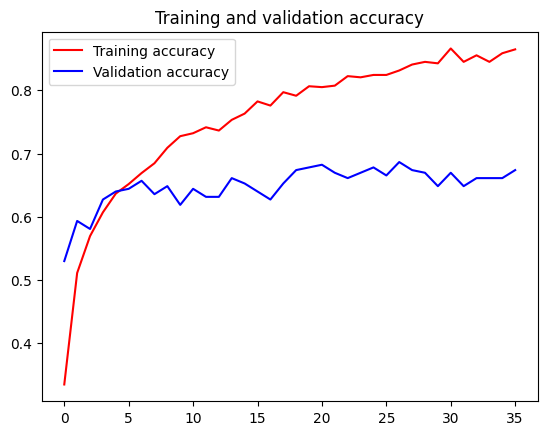

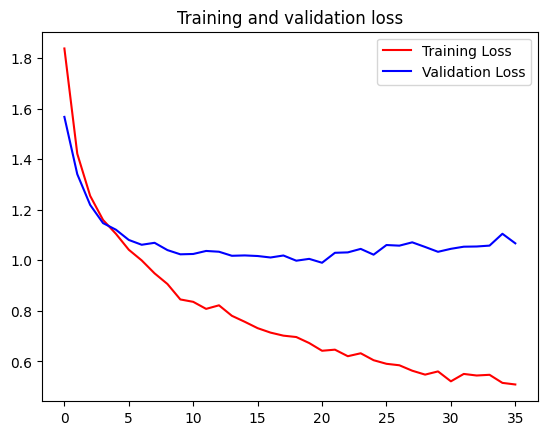

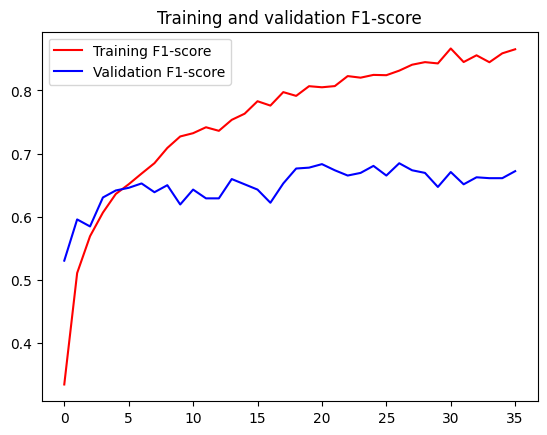

In [ ]:
plot_model_history(history_efficient)

<a id='fine-tune'></a>
### Fine-tune model

In [ ]:
optimizer_efficient_ft = Adam(learning_rate=1e-4)
unfreeze_model(model_efficient, optimizer_efficient_ft)

total_params = model_efficient.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model_efficient.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 53,237,882 total parameters in this model.
There are 52,943,290 trainable parameters in this model.


In [ ]:
history_efficient_ft = model_efficient.fit(train_ds, validation_data = val_ds, epochs=100, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
133/133 [==============================] - 264s 938ms/step - loss: 0.9604 - accuracy: 0.7232 - micro_f1_score: 0.7232 - val_loss: 0.6919 - val_accuracy: 0.8220 - val_micro_f1_score: 0.8208 - lr: 1.0000e-04
Epoch 2/100
133/133 [==============================] - 116s 870ms/step - loss: 0.5376 - accuracy: 0.8555 - micro_f1_score: 0.8557 - val_loss: 0.4040 - val_accuracy: 0.8941 - val_micro_f1_score: 0.8944 - lr: 1.0000e-04
Epoch 3/100
133/133 [==============================] - 116s 869ms/step - loss: 0.3547 - accuracy: 0.9223 - micro_f1_score: 0.9225 - val_loss: 0.5478 - val_accuracy: 0.8517 - val_micro_f1_score: 0.8514 - lr: 1.0000e-04
Epoch 4/100
133/133 [==============================] - 117s 879ms/step - loss: 0.3156 - accuracy: 0.9289 - micro_f1_score: 0.9290 - val_loss: 0.7892 - val_accuracy: 0.8432 - val_micro_f1_score: 0.8403 - lr: 1.0000e-04
Epoch 5/100
133/133 [==============================] - 116s 869ms/step - loss: 0.2917 - accuracy: 0.9440 - micro_f1_score: 0.943

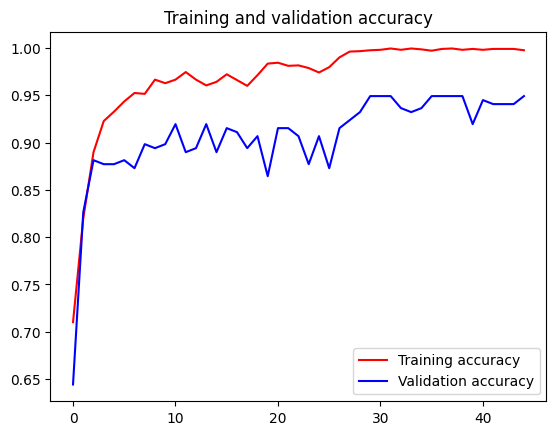

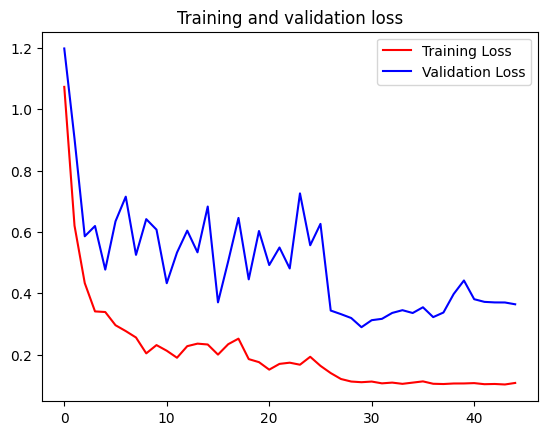

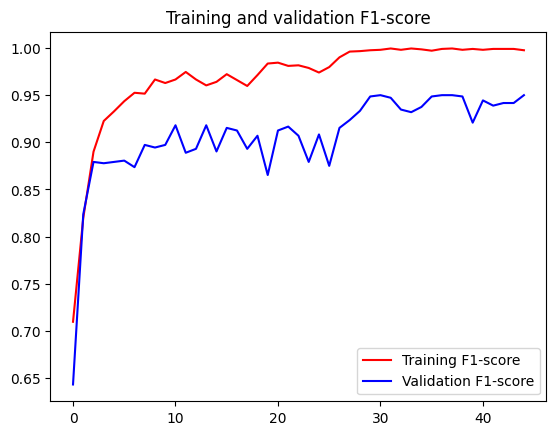

In [ ]:
plot_model_history(history_efficient_ft)

In [ ]:
model_efficient.save("efficient_net_v2m.h5")

## DenseNet201

In [42]:
def build_densenet_model():
    base_model = DenseNet201(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze the pretrained weights
    base_model.trainable = False

    # Augmantation sequence
    intput_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmantation = Sequential([
        Rescaling(1/255),
        RandomFlip("horizontal"),
        RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
        RandomZoom(0.2)
    ])
    x = augmantation(intput_layer)

    # pretrain output
    pretrain_out = base_model(x, training = False)

    # Rebuild top
    x = GlobalAveragePooling2D()(pretrain_out)
    x = BatchNormalization()(x)
    x = Dense(48, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)

    # Add a dropout rate
    x = Dropout(0.2)(x)

    # Output layer
    outputs = Dense(6, activation="softmax")(x)

    # Compile
    model = tf.keras.Model(inputs=intput_layer, outputs=outputs, name="DenseNet201")
    model.compile(optimizer=SGD(learning_rate=1e-2), loss="categorical_crossentropy", metrics=["accuracy", micro_f1_score])

    return model

In [44]:
model_densenet = build_densenet_model()
model_densenet.summary()

74836368/74836368 [==============================] - 3s 0us/step
Model: "DenseNet201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                        

In [45]:
history = model_densenet.fit(train_ds, validation_data = val_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
133/133 [==============================] - 36s 169ms/step - loss: 1.6021 - accuracy: 0.3809 - micro_f1_score: 0.3816 - val_loss: 1.2762 - val_accuracy: 0.5466 - val_micro_f1_score: 0.5472
Epoch 2/100
133/133 [==============================] - 18s 134ms/step - loss: 1.1652 - accuracy: 0.5749 - micro_f1_score: 0.5747 - val_loss: 1.0989 - val_accuracy: 0.6017 - val_micro_f1_score: 0.6042
Epoch 3/100
133/133 [==============================] - 20s 144ms/step - loss: 1.0212 - accuracy: 0.6234 - micro_f1_score: 0.6233 - val_loss: 1.0146 - val_accuracy: 0.6314 - val_micro_f1_score: 0.6319
Epoch 4/100
133/133 [==============================] - 20s 143ms/step - loss: 0.9179 - accuracy: 0.6601 - micro_f1_score: 0.6599 - val_loss: 0.9914 - val_accuracy: 0.6568 - val_micro_f1_score: 0.6556
Epoch 5/100
133/133 [==============================] - 19s 137ms/step - loss: 0.8598 - accuracy: 0.6808 - micro_f1_score: 0.6812 - val_loss: 0.9628 - val_accuracy: 0.6568 - val_micro_f1_score: 0.6569


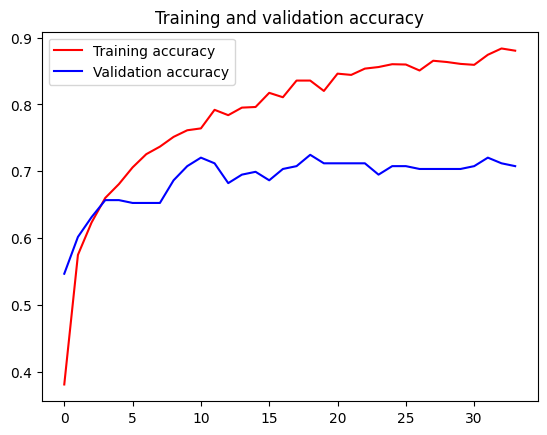

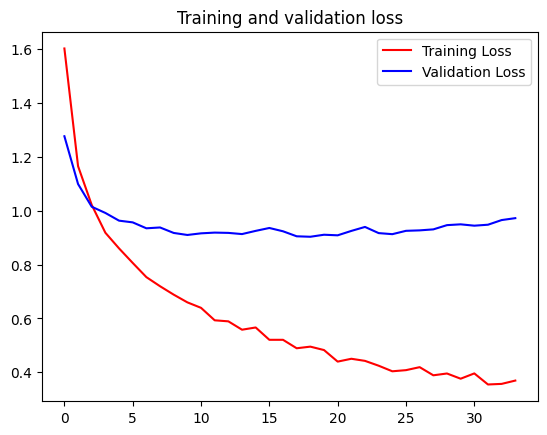

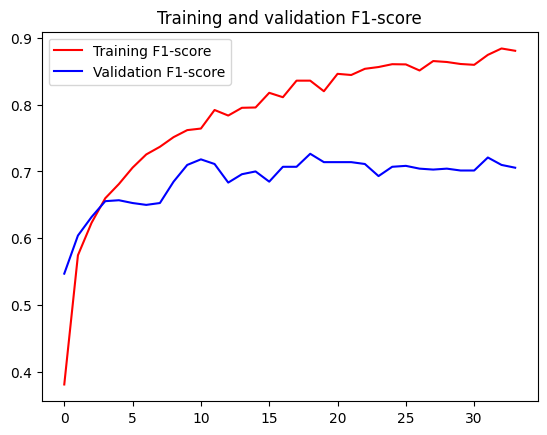

In [46]:
plot_model_history(history)

<a id='fine-tune'></a>
### Fine-tune model

In [ ]:
print(f'Model layers amount: {len(model_densenet.layers)}')

Model layers amount: 8


In [48]:
unfreeze_model(model_densenet, Adam(learning_rate=1e-4))

total_params = model_densenet.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model_densenet.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 18,422,166 total parameters in this model.
There are 18,189,270 trainable parameters in this model.


In [49]:
early_stopping_unfreezed = EarlyStopping('val_loss', patience=7, restore_best_weights=True)

In [ ]:
history = model_densenet.fit(train_ds, validation_data = val_ds, epochs=100, callbacks=[reduce_lr, early_stopping_unfreezed])

Epoch 1/100


In [ ]:
plot_model_history(history)

## Second model

In [ ]:
def build_mobilenet_model():
    base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze the pretrained weights
    base_model.trainable = False

    # Augmantation sequence
    intput_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmantation = Sequential([
        Rescaling(1/255),
        RandomFlip("horizontal"),
        RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
        RandomZoom(0.2)
    ])
    x = augmantation(intput_layer)

    # pretrain output
    pretrain_out = base_model(x, training = False)

    # Rebuild top
    x = GlobalAveragePooling2D()(pretrain_out)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)

    # Add a dropout rate
    x = Dropout(0.2)(x)

    # Output layer
    outputs = Dense(6, activation="softmax")(x)

    # Compile
    model = tf.keras.Model(inputs=intput_layer, outputs=outputs, name="MobileNetV2")
    model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy", micro_f1_score])

    return model

In [ ]:
model_mobilenet = build_mobilenet_model()
total_params = model_mobilenet.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model_mobilenet.trainable_weights])

model_mobilenet.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                       

In [ ]:
history_mobilenet = model_mobilenet.fit(train_ds, validation_data = val_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
133/133 [==============================] - 19s 98ms/step - loss: 1.6553 - accuracy: 0.4355 - micro_f1_score: 0.4355 - val_loss: 1.2102 - val_accuracy: 0.5551 - val_micro_f1_score: 0.5569
Epoch 2/100
133/133 [==============================] - 12s 89ms/step - loss: 1.0294 - accuracy: 0.6205 - micro_f1_score: 0.6208 - val_loss: 1.1434 - val_accuracy: 0.6059 - val_micro_f1_score: 0.6056
Epoch 3/100
133/133 [==============================] - 13s 94ms/step - loss: 0.9007 - accuracy: 0.6874 - micro_f1_score: 0.6875 - val_loss: 1.1628 - val_accuracy: 0.5890 - val_micro_f1_score: 0.5889
Epoch 4/100
133/133 [==============================] - 12s 90ms/step - loss: 0.7636 - accuracy: 0.7279 - micro_f1_score: 0.7278 - val_loss: 1.1117 - val_accuracy: 0.5890 - val_micro_f1_score: 0.5931
Epoch 5/100
133/133 [==============================] - 13s 94ms/step - loss: 0.7004 - accuracy: 0.7476 - micro_f1_score: 0.7472 - val_loss: 1.0767 - val_accuracy: 0.6314 - val_micro_f1_score: 0.6319
Epoch

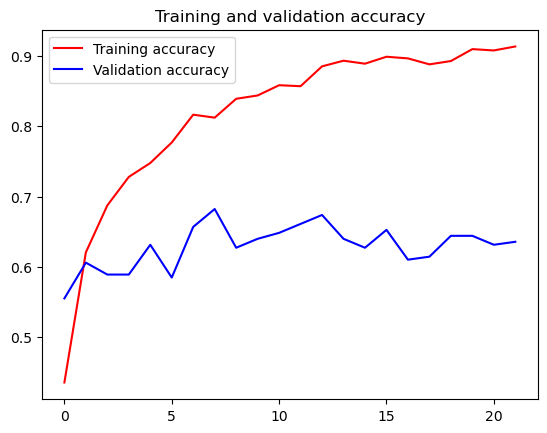

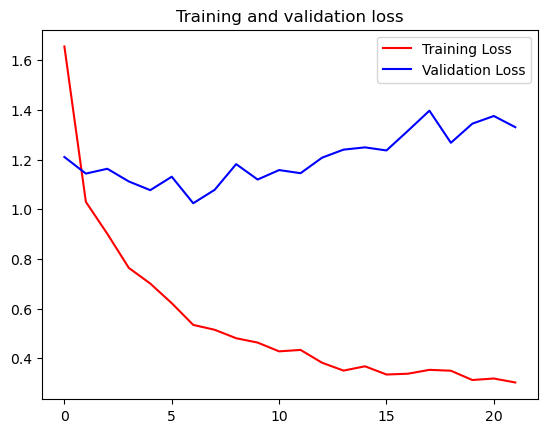

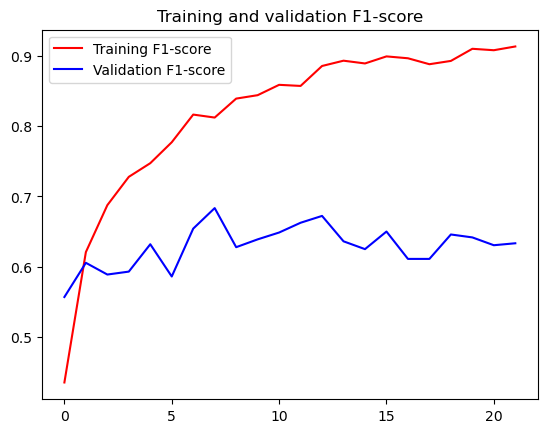

In [ ]:
plot_model_history(history_mobilenet)

In [ ]:
unfreeze_model(model_mobilenet)

total_params = model_mobilenet.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model_mobilenet.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 2,427,846 total parameters in this model.
There are 2,391,174 trainable parameters in this model.


In [ ]:
history_mobilenet = model_mobilenet.fit(train_ds, validation_data = val_ds, epochs=100, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
133/133 [==============================] - 47s 120ms/step - loss: 1.2427 - accuracy: 0.5556 - micro_f1_score: 0.5553 - val_loss: 2.1912 - val_accuracy: 0.4831 - val_micro_f1_score: 0.4847 - lr: 1.0000e-04
Epoch 2/100
133/133 [==============================] - 15s 106ms/step - loss: 0.9793 - accuracy: 0.6460 - micro_f1_score: 0.6457 - val_loss: 1.5404 - val_accuracy: 0.5466 - val_micro_f1_score: 0.5444 - lr: 1.0000e-04
Epoch 3/100
133/133 [==============================] - 15s 111ms/step - loss: 0.8986 - accuracy: 0.6883 - micro_f1_score: 0.6878 - val_loss: 1.9019 - val_accuracy: 0.5551 - val_micro_f1_score: 0.5569 - lr: 1.0000e-04
Epoch 4/100
133/133 [==============================] - 14s 105ms/step - loss: 0.7495 - accuracy: 0.7326 - micro_f1_score: 0.7325 - val_loss: 0.8451 - val_accuracy: 0.7373 - val_micro_f1_score: 0.7403 - lr: 1.0000e-04
Epoch 5/100
133/133 [==============================] - 15s 109ms/step - loss: 0.5886 - accuracy: 0.7990 - micro_f1_score: 0.7986 - v

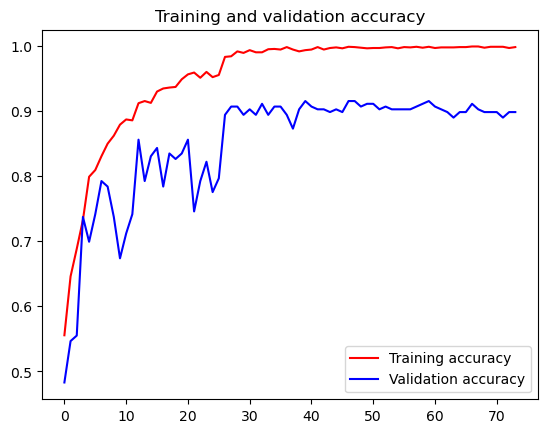

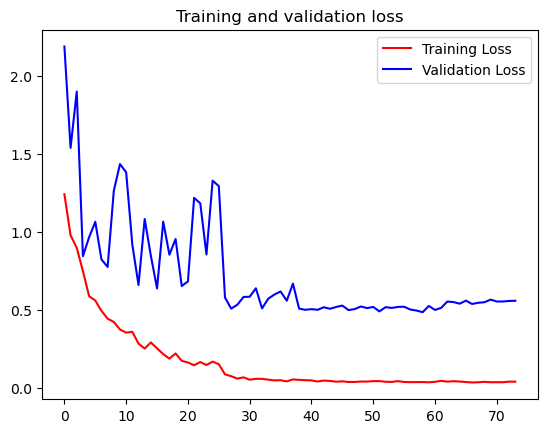

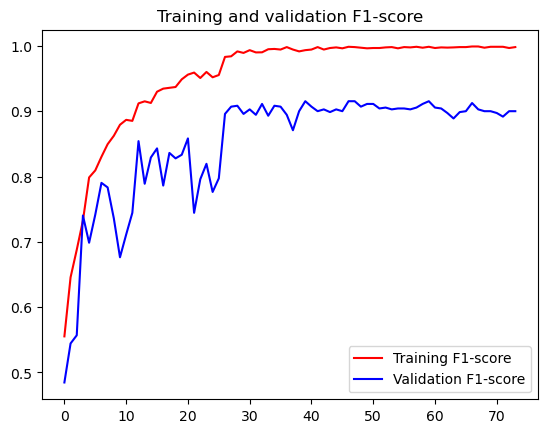

In [ ]:
plot_model_history(history_mobilenet)

## Ensemble

In [ ]:
def create_ensemble(models):
    input_layer = Input(shape=(224, 224, 3))  # input layer

    # get output for each input model
    outputs = [model(input_layer) for model in models]

    # take average of the outputs
    x = Average()(outputs)

    # final layer
    output = Dense(6, activation="softmax")(x)

    # create average ensembled model
    avg_model = Model(input_layer, output)

    avg_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", micro_f1_score])

    return avg_model

In [ ]:
models = [model_densenet, model_mobilenet]
ensemble = create_ensemble(models)
ensemble.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 DenseNet201 (Functional)       (None, 6)            18576326    ['input_13[0][0]']               
                                                                                                  
 MobileNetV2 (Functional)       (None, 6)            2427846     ['input_13[0][0]']               
                                                                                                  
 average_6 (Average)            (None, 6)            0           ['DenseNet201[6][0]',      

In [ ]:
history_ensemble = ensemble.fit(train_ds, validation_data = val_ds, epochs=100, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
133/133 [==============================] - 190s 319ms/step - loss: 1.7863 - accuracy: 0.2382 - micro_f1_score: 0.2381 - val_loss: nan - val_accuracy: 0.2161 - val_micro_f1_score: 0.2167 - lr: 0.0010
Epoch 2/100
133/133 [==============================] - 39s 289ms/step - loss: 1.7451 - accuracy: 0.2556 - micro_f1_score: 0.2555 - val_loss: nan - val_accuracy: 0.2161 - val_micro_f1_score: 0.2167 - lr: 0.0010
Epoch 3/100
133/133 [==============================] - 39s 289ms/step - loss: 1.7333 - accuracy: 0.2556 - micro_f1_score: 0.2556 - val_loss: nan - val_accuracy: 0.2161 - val_micro_f1_score: 0.2153 - lr: 0.0010
Epoch 4/100
133/133 [==============================] - 39s 286ms/step - loss: 1.7272 - accuracy: 0.2556 - micro_f1_score: 0.2556 - val_loss: nan - val_accuracy: 0.2161 - val_micro_f1_score: 0.2167 - lr: 0.0010
Epoch 5/100
133/133 [==============================] - 39s 288ms/step - loss: 1.7242 - accuracy: 0.2556 - micro_f1_score: 0.2555 - val_loss: nan - val_accuracy

<a id='test-data'></a>
# Test data

In [ ]:
# remove loaded images from the output folder
shutil.rmtree(preprocessed_train_images_dir)
shutil.rmtree(preprocessed_val_images_dir)

<a id='test-preprocessing'></a>
## Preprocessing

In [31]:
image_filenames = os.listdir(TEST_IMAGES_SRC_PATH)
len(image_filenames)

756

In [32]:
resizer = Resizing(IMG_SIZE, IMG_SIZE, interpolation='bilinear')

In [33]:
def preprocess_test_img(img_path):
    #img = rembg(img_path) # remove background
    #img = img.convert("RGB") # remove alpha
    img = load_img(img_path) # image loading
    img_arr = img_to_array(img) # convert image to numpy array
    img_arr = resizer(img_arr) # resize
    return img_arr

In [34]:
test_data_preprocessed = [preprocess_test_img(TEST_IMAGES_SRC_PATH + img) for img in image_filenames]

In [35]:
X_test = np.stack(test_data_preprocessed, axis=0)
X_test.shape

(756, 256, 256, 3)

In [37]:
image_filenames[:5]

['1f9f120d73c6e33b2802aa4262353ced.jpg',
 '67127cfc816be9edd786c61cc871e993.jpg',
 '5ca77a78e13dd7231a54b64615986c6d.jpg',
 'fddf6b7bb409b905d6d42b334dbe5a6d.jpg',
 'abf9d524764d9e500b1bbcfc765dc717.jpg']

<a id='inference'></a>
## Inference

In [ ]:
### Load efficient_nev_v2m with 0.91749 score

best_efficientnet_model = tf.keras.models.load_model('efficient_net_v2m.h5',
                                                    custom_objects={'micro_f1_score': micro_f1_score})

In [38]:
def soft_voting_predictions(all_probabilities):
    # Average the probabilities from all models
    avg_probabilities = np.mean(np.stack(all_probabilities, axis=0), axis=0)
    print(f"Shape of avg_probabilities: {avg_probabilities.shape}")

    # Convert averaged probabilities to final predictions
    final_preds = np.argmax(avg_probabilities, axis=-1)
    print(f"Shape of final_preds: {final_preds.shape}")

    return final_preds

In [ ]:
models = [last_densenet_model, best_efficientnet_model]
all_predictions = []
for model in models:
     all_predictions.append(model.predict(X_test))

predicted_classes = soft_voting_predictions(all_predictions)

In [ ]:
predictions = model_efficient.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

24/24 [==============================] - 13s 305ms/step


In [ ]:
df_predictions = pd.DataFrame({
    'image_id': image_filenames,
    'class_6': predicted_classes
})

In [ ]:
df_predictions.head()

,image_id,class_6
0,1f9f120d73c6e33b2802aa4262353ced.jpg,4
1,67127cfc816be9edd786c61cc871e993.jpg,0
2,5ca77a78e13dd7231a54b64615986c6d.jpg,4
3,fddf6b7bb409b905d6d42b334dbe5a6d.jpg,5
4,abf9d524764d9e500b1bbcfc765dc717.jpg,4


In [ ]:
df_predictions['class_6'].value_counts()

4    179
0    174
1    154
2    100
5     80
3     69
Name: class_6, dtype: int64

In [ ]:
df_predictions.to_csv('submission.csv', index=False)